# Import libraries

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np
np.random.seed(13)

In [0]:
# Download data in google colab, no need to run this in your laptops

# Just in case...
!rm -rf ml-latest-small*
!wget http://files.grouplens.org/datasets/movielens/ml-latest-small.zip
!unzip ml-latest-small.zip

--2019-02-25 10:53:05--  http://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.34.235
Connecting to files.grouplens.org (files.grouplens.org)|128.101.34.235|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 978202 (955K) [application/zip]
Saving to: ‘ml-latest-small.zip’

ml-latest-small.zip 100%[===================>] 955.28K  4.09MB/s    in 0.2s    

2019-02-25 10:53:05 (4.09 MB/s) - ‘ml-latest-small.zip’ saved [978202/978202]

Archive:  ml-latest-small.zip
   creating: ml-latest-small/
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  


# Load data

In [0]:
data = pd.read_csv("ml-latest-small/ratings.csv", index_col='timestamp', parse_dates=['timestamp'], date_parser = lambda x: datetime.datetime.fromtimestamp(int(x)))

## Process data
**Assumption**: one rating = one request

In [0]:
del data['userId']
data.head()

,movieId,rating
timestamp,,
2000-07-30 18:45:03,1,4.0
2000-07-30 18:20:47,3,4.0
2000-07-30 18:37:04,6,4.0
2000-07-30 19:03:35,47,5.0
2000-07-30 18:48:51,50,5.0


In [0]:
def assign_class(n_req, total_req):
    """
    assign class based on the no. of request received
    """
    
    # top 1% of the day are Class 1
    if n_req > 0.01 * total_req:
        return 1
    # top 0.5% of the day are Class 2
    elif n_req > 0.005 * total_req:
        return 2
    # top 0.01% of the day are Class 3
    elif n_req > 0.001 * total_req:
        return 3
    # rest are Class 4
    else:
        return 4

In [0]:
def group_movies(daywise_group):
    """
    add request probablity to input pandas DataFrame
    
    :param daywise_group: a DataFrame containing movieId and corresponding ratings for a single day.
    """
    df = daywise_group.groupby("movieId").count()
    # `rating` column now holds the no. of requests, so rename the column to avoid confusion
    df.rename(columns={"rating":"req"}, inplace=True)
    df['totalReq'] = daywise_group.shape[0]
    # request probablity for that day
    df['reqProb'] = daywise_group.groupby("movieId").count()['rating'] / df['totalReq']
    return df

In [0]:
grouped_by_movie = data.resample("1w").apply(group_movies)
grouped_by_movie['class'] = grouped_by_movie[['req', 'totalReq']].apply(lambda x:assign_class(x['req'], x['totalReq']), axis=1)
grouped_by_movie.reset_index(level='movieId', inplace=True)
grouped_by_movie.head()

,movieId,req,totalReq,reqProb,class
timestamp,,,,,
1996-03-31,22,1,58,0.017241,1
1996-03-31,48,1,58,0.017241,1
1996-03-31,60,1,58,0.017241,1
1996-03-31,150,1,58,0.017241,1
1996-03-31,151,1,58,0.017241,1


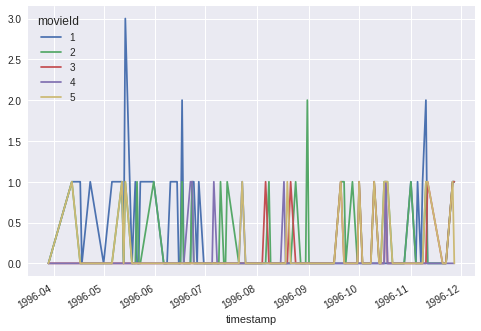

In [0]:
grouped_by_movie.pivot(columns='movieId', values='req').fillna(0).iloc[:100,:5].plot()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,movieId,req,reqProb,class,Y
timestamp,,,,,
2000-04-26,1,7,0.001579,3,3
2000-04-27,1,3,0.001603,3,3
2000-04-28,1,3,0.001309,3,3
2000-04-29,1,3,0.001845,3,3
2000-04-30,1,1,0.001013,3,3


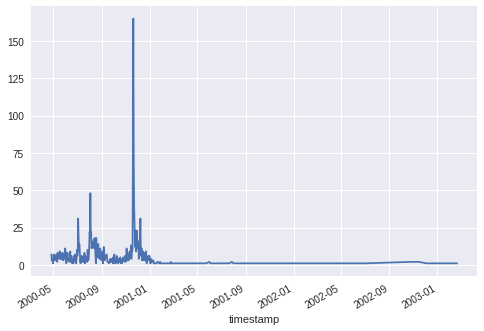

In [0]:
movie_history = grouped_by_movie[grouped_by_movie['movieId'] == 1]
movie_history['Y'] = np.roll(movie_history['class'], -1)
movie_history['req'].plot()
del movie_history['totalReq']
movie_history.head()

# Crunching numbers!

In [0]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
# One-hot-encode classes
preprocess = make_column_transformer([OneHotEncoder(categories=[np.array([1,2,3,4])]), ['class', 'Y']])
values = movie_history.values
one_hot_encoded = np.concatenate((list(map(lambda x:np.eye(4)[x-1], values[:,3].astype('int')) ),
               list(map(lambda x:np.eye(4)[x-1], values[:,4].astype('int')))), axis=1)
values = np.concatenate((movie_history.values[:,:3], one_hot_encoded), axis=1)

# Scale 
scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(values)
scaled_values.shape

(336, 11)

## Make X and Y

In [0]:
X = scaled_values[:,:7]
y = scaled_values[:,7:]
# reshape
X = X.reshape(X.shape[0], 1, 7)
y = y.reshape(y.shape[0], 1, 4)
print(X.shape)
print(y.shape)

(336, 1, 7)
(336, 1, 4)


## train_test_split

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=False)

# Make Model

In [0]:
from keras.models import Sequential
from keras.layers import Dropout, LSTM, BatchNormalization, TimeDistributed, Dense, Activation
model = Sequential()
model.add(BatchNormalization(input_shape=(1,X_train.shape[2])))
model.add(LSTM(4, return_sequences=True))
model.add(LSTM(1, dropout=0.2, return_sequences=True))
model.add(TimeDistributed(Dense(y_train.shape[2])))
model.add(Activation('softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 1, 7)              28        
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 4)              192       
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 1)              24        
_________________________________________________________________
time_distributed_1 (TimeDist (None, 1, 4)              8         
_________________________________________________________________
activation_1 (Activation)    (None, 1, 4)              0         
Total params: 252
Trainable params: 238
Non-trainable params: 14
______________________

In [0]:
history = model.fit(X_train, y_train, batch_size=10, epochs=10)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/10
225/225 [==============================] - 2s 9ms/step - loss: 1.3751 - acc: 0.6756
Epoch 2/10
225/225 [==============================] - 0s 357us/step - loss: 1.3319 - acc: 0.8178
Epoch 3/10
225/225 [==============================] - 0s 381us/step - loss: 1.2859 - acc: 0.8800
Epoch 4/10
225/225 [==============================] - 0s 362us/step - loss: 1.2399 - acc: 0.8933
Epoch 5/10
225/225 [==============================] - 0s 406us/step - loss: 1.1831 - acc: 0.9244
Epoch 6/10
225/225 [==============================] - 0s 393us/step - loss: 1.1302 - acc: 0.9200
Epoch 7/10
225/225 [==============================] - 0s 352us/step - loss: 1.0693 - acc: 0.9244
Epoch 8/10
225/225 [==============================] - 0s 355us/step - loss: 1.0105 - acc: 0.9244
Epoch 9/10
225/225 [==============================] - 0s 347us/step - loss: 0.9434 - acc: 0.9244
Epo

In [0]:
score, acc = model.evaluate(X_test, y_test,
                            batch_size=100)
print('Test score:', score)
print('Test accuracy:', acc)

111/111 [==============================] - 0s 2ms/step
Test score: 1.189915159801105
Test accuracy: 0.5585585805746887
